
# Yield Curve Analysis with Real Market Data

### Overview
This notebook provides a comprehensive framework for analyzing the U.S. Treasury yield curve using real-time market data. As a critical component of institutional Asset-Liability Management (ALM), understanding the term structure of interest rates is essential for valuation, risk measurement, and strategic positioning.

### Objectives
- **Data Acquisition**: Fetch current Treasury yields across the maturity spectrum from the Federal Reserve Economic Data (FRED) database.
- **Curve Construction**: Build a continuous yield curve using institutional-grade interpolation methods.
- **Nelson-Siegel Fitting**: Parametrize the curve to understand the underlying level, slope, and curvature components.
- **Forward Rate Analysis**: Calculate implied forward rates to extract market expectations of future rate environments.
- **Scenario Analysis**: Stress test the portfolio against parallel shifts and non-parallel (steepening/flattening) curve movements.

### Buy-Side Application
For portfolio managers, this analysis informs duration positioning, identify relative value opportunities along the curve, and quantifies the impact of potential monetary policy shifts on fixed-income holdings.


In [43]:
import datetime
from datetime import timedelta
import warnings
import numpy as np
import pandas as pd

# Workaround for pandas_datareader incompatibility with recent pandas versions (including Pandas 3.0+)
try:
    import pandas as pd
    import inspect
    import warnings
    
    def patch_pandas_deprecate():
        # Target both possible locations for deprecate_kwarg
        for mod_name in ['pandas.util._exceptions', 'pandas.util._decorators']:
            try:
                mod = __import__(mod_name, fromlist=['deprecate_kwarg'])
                if hasattr(mod, 'deprecate_kwarg'):
                    orig_func = mod.deprecate_kwarg
                    sig = inspect.signature(orig_func)
                    # If 'klass' is the first parameter, it's the new signature that breaks pdr
                    if 'klass' in sig.parameters:
                        def patched_func(*args, **kwargs):
                            if len(args) >= 1 and isinstance(args[0], str):
                                return orig_func(FutureWarning, *args, **kwargs)
                            return orig_func(*args, **kwargs)
                        mod.deprecate_kwarg = patched_func
            except (ImportError, AttributeError):
                continue
    patch_pandas_deprecate()
except Exception:
    pass

import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from models.interest_rate.yield_curve import YieldCurve, NelsonSiegelParams

# Suppress warnings for cleaner presentation
warnings.filterwarnings('ignore')

# Set up matplotlib styling
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print(f"Libraries imported successfully.")
print(f"Analysis Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Libraries imported successfully.
Analysis Date: 2026-02-13 19:17:05



## Data Collection: FRED Treasury Series

We utilize the Federal Reserve Economic Data (FRED) API via `pandas_datareader` to fetch the most recent Constant Maturity Treasury (CMT) rates. This data represents the yields on actively traded Treasury securities adjusted to specific tenors.

The following series are collected:
- **Short-term**: 1 Month (DGS1MO), 3 Month (DGS3MO), 6 Month (DGS6MO)
- **Medium-term**: 1 Year (DGS1), 2 Year (DGS2), 3 Year (DGS3), 5 Year (DGS5), 7 Year (DGS7)
- **Long-term**: 10 Year (DGS10), 20 Year (DGS20), 30 Year (DGS30)

No API key is required for basic FRED data access.


In [44]:
# Define Treasury series mapping (FRED code -> Tenor in years)
treasury_series = {
    'DGS1MO': 1/12,
    'DGS3MO': 0.25,
    'DGS6MO': 0.5,
    'DGS1': 1.0,
    'DGS2': 2.0,
    'DGS3': 3.0,
    'DGS5': 5.0,
    'DGS7': 7.0,
    'DGS10': 10.0,
    'DGS20': 20.0,
    'DGS30': 30.0
}

# Global variable to store historical data for trend analysis
historical_data = None

def fetch_treasury_data():
    global historical_data
    end_date = datetime.datetime.now()
    start_date = end_date - timedelta(days=60) # Increased to 60 days for better trend visuals
    
    try:
        print("Fetching data from FRED...")
        df = pdr.get_data_fred(list(treasury_series.keys()), start_date, end_date)
        historical_data = df.copy()
        
        # Get the most recent row that doesn't have all NaNs
        latest_data = df.dropna(how='all').iloc[-1]
        last_date = latest_data.name.strftime('%Y-%m-%d')
        print(f"Successfully retrieved data for {last_date}")
        
        clean_df = pd.DataFrame({
            'Series': latest_data.index,
            'Tenor (Years)': [treasury_series[code] for code in latest_data.index],
            'Yield (%)': latest_data.values
        })
        return clean_df.sort_values('Tenor (Years)')
    
    except Exception as e:
        print(f"Error fetching FRED data: {e}")
        print("Falling back to synthetic institutional data for analysis...")
        # Fallback synthetic data (typical inverted/flat curve profile)
        synthetic_yields = [5.40, 5.35, 5.25, 5.00, 4.65, 4.45, 4.25, 4.20, 4.15, 4.35, 4.30]
        clean_df = pd.DataFrame({
            'Series': list(treasury_series.keys()),
            'Tenor (Years)': list(treasury_series.values()),
            'Yield (%)': synthetic_yields
        })
        return clean_df.sort_values('Tenor (Years)')

current_curve = fetch_treasury_data()
current_curve


Fetching data from FRED...
Successfully retrieved data for 2026-02-12


,Series,Tenor (Years),Yield (%)
0,DGS1MO,0.083333,3.72
1,DGS3MO,0.250000,3.70
2,DGS6MO,0.500000,3.58
3,DGS1,1.000000,3.45
4,DGS2,2.000000,3.47
5,DGS3,3.000000,3.49
6,DGS5,5.000000,3.67
7,DGS7,7.000000,3.87
8,DGS10,10.000000,4.09
9,DGS20,20.000000,4.68


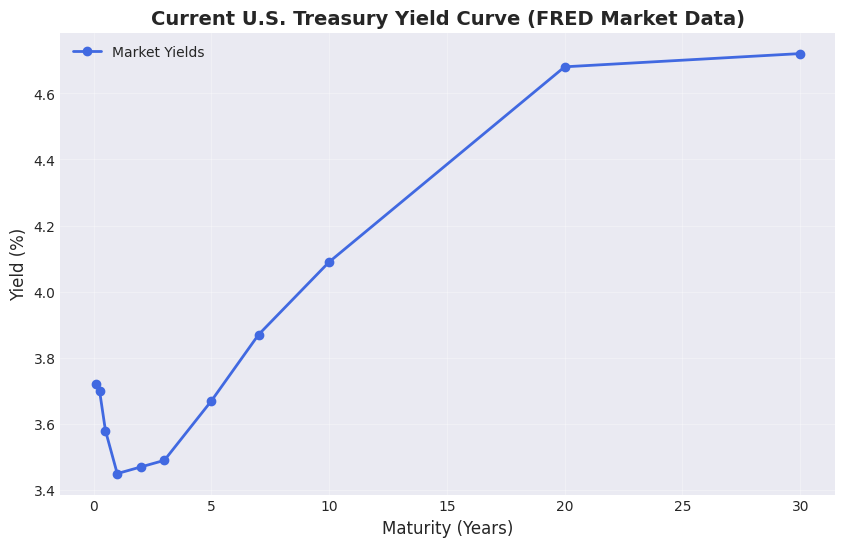

In [45]:
# Visualizing the Current Treasury Yield Curve
plt.figure(figsize=(10, 6))
plt.plot(current_curve['Tenor (Years)'], current_curve['Yield (%)'], 'o-', color='royalblue', lw=2, label='Market Yields')
plt.title('Current U.S. Treasury Yield Curve (FRED Market Data)', fontweight='bold')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Yield Curve Construction

While the FRED data provides discrete points, financial modeling requires a continuous yield function. We use our `YieldCurve` class to construct this object. 

**Interpolation Method**: Linear interpolation on spot rates with flat extrapolation. This method ensures that we honor the observed market rates exactly at the provided tenors while providing a robust estimation for intermediate dates.


In [46]:
# Extract tenors and rates (convert % to decimal)
tenors = current_curve['Tenor (Years)'].values
rates = current_curve['Yield (%)'].values / 100.0

# Create market_curve object using our internal library
market_curve = YieldCurve.from_spot_rates(tenors, rates)

# Test interpolation at key non-observed tenors
test_tenors = [0.75, 4.0, 15.0, 25.0]
print(f"Interpolated Rates Analysis:")
print("-" * 30)
for t in test_tenors:
    rate = market_curve.spot_rate(t)
    print(f"{t:>5} Year Tenor: {rate*100:.4f}%")


Interpolated Rates Analysis:
------------------------------
 0.75 Year Tenor: 3.5150%
  4.0 Year Tenor: 3.5800%
 15.0 Year Tenor: 4.3850%
 25.0 Year Tenor: 4.7000%



## Yield Curve Visualization

Visual inspection of the curve is the first step in identifying market regimes (e.g., expansion, recession signals). We analyze the slope through key spreads like 2s10s (a traditional recession indicator) and 5s30s.


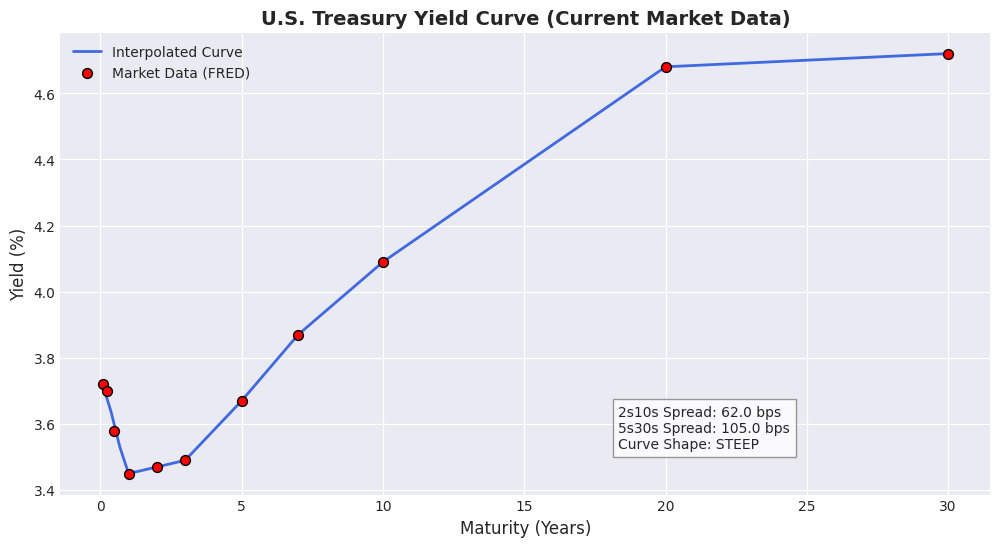

In [47]:
# Generate smooth grid for plotting
t_grid = np.linspace(min(tenors), max(tenors), 100)
r_grid = [market_curve.spot_rate(t) * 100 for t in t_grid]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t_grid, r_grid, label='Interpolated Curve', color='royalblue', lw=2, zorder=1)
plt.scatter(tenors, rates * 100, color='red', edgecolor='black', s=50, label='Market Data (FRED)', zorder=2)

# Spreads Calculation
s2 = market_curve.spot_rate(2.0) * 100
s10 = market_curve.spot_rate(10.0) * 100
s5 = market_curve.spot_rate(5.0) * 100
s30 = market_curve.spot_rate(30.0) * 100
spread_2s10s = (s10 - s2) * 100  # in bps
spread_5s30s = (s30 - s5) * 100  # in bps

# Determine Shape Assessment
if spread_2s10s > 50:
    shape_val = "STEEP"
elif spread_2s10s >= 0:
    shape_val = "NORMAL"
elif spread_2s10s >= -50:
    shape_val = "FLAT"
else:
    shape_val = "INVERTED"

# Annotations
stats_text = (f"2s10s Spread: {spread_2s10s:.1f} bps\n"
              f"5s30s Spread: {spread_5s30s:.1f} bps\n"
              f"Curve Shape: {shape_val}")
plt.gca().text(0.6, 0.1, stats_text, transform=plt.gca().transAxes, 
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.title("U.S. Treasury Yield Curve (Current Market Data)", fontweight='bold')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.show()



## Implied Forward Rates

Forward rates are the interest rates for a period of time in the future, implied by the current spot curve. They represent the \"break-even\" rate that would make an investor indifferent between a long-term investment and a series of shorter-term investments.

**Buy-Side Application**: Forward rates provide a benchmark for evaluating whether current long-term yields offer sufficient compensation for expected future rate hikes.


In [48]:
# Calculate key forward rates
forwards = {
    '1y1y': market_curve.forward_rate(1.0, 2.0),
    '2y1y': market_curve.forward_rate(2.0, 3.0),
    '2y3y': market_curve.forward_rate(2.0, 5.0),
    '5y5y': market_curve.forward_rate(5.0, 10.0),
    '10y10y': market_curve.forward_rate(10.0, 20.0),
    '10y20y': market_curve.forward_rate(10.0, 30.0)
}

forward_df = pd.DataFrame({
    'Forward Rate': list(forwards.keys()),
    'Rate (%)': [v * 100 for v in forwards.values()],
    'Interpretation': [
        '1Y rate in 1Y', '1Y rate in 2Y', '3Y rate in 2Y', 
        '5Y rate in 5Y', '10Y rate in 10Y', '20Y rate in 10Y'
    ]
})

print("Implied Forward Rates Analysis:")
print(forward_df)

f5y5y = forwards['5y5y'] * 100
s10y = market_curve.spot_rate(10.0) * 100

print(f"\nMarket Expectation Insight:")
print(f"5Y5Y Forward ({f5y5y:.2f}%) vs 10Y Spot ({s10y:.2f}%)")
if f5y5y > s10y:
    print("Conclusion: The market expects long-term rates to rise or remain elevated compared to today's levels.")
else:
    print("Conclusion: The market expects rates to fall or the curve to remain inverted/flat in the long term.")


Implied Forward Rates Analysis:
  Forward Rate  Rate (%)   Interpretation
0         1y1y  3.490004    1Y rate in 1Y
1         2y1y  3.530012    1Y rate in 2Y
2         2y3y  3.803548    3Y rate in 2Y
3         5y5y  4.511702    5Y rate in 5Y
4       10y10y  5.273344  10Y rate in 10Y
5       10y20y  5.036428  20Y rate in 10Y

Market Expectation Insight:
5Y5Y Forward (4.51%) vs 10Y Spot (4.09%)
Conclusion: The market expects long-term rates to rise or remain elevated compared to today's levels.



## Parametric Modeling: Nelson-Siegel

The Nelson-Siegel model fits the yield curve using four parameters:
- **Beta 0 ($\beta_0$):** Long-term level (asymptote).
- **Beta 1 ($\beta_1$):** Short-term component (slope).
- **Beta 2 ($\beta_2$):** Medium-term component (curvature/hump).
- **Tau ($\tau$):** Scale parameter governing the location of the hump.

**Buy-Side Use**: It allows for smooth curve construction and provides a compact way to describe curve dynamics for risk management and historical comparison.


In [49]:
# Estimate initial parameters for Nelson-Siegel
b0_init = market_curve.spot_rate(30.0)
b1_init = market_curve.spot_rate(0.25) - b0_init
b2_init = 0.01
tau_init = 2.0

ns_params = NelsonSiegelParams(beta0=b0_init, beta1=b1_init, beta2=b2_init, tau=tau_init)
ns_curve = YieldCurve.from_nelson_siegel(ns_params, tenors=tenors)

print("Nelson-Siegel Model Parameters:")
print(f"Beta 0 (Level): {ns_params.beta0*100:.4f}%")
print(f"Beta 1 (Slope): {ns_params.beta1*100:.4f}%")
print(f"Beta 2 (Curvature): {ns_params.beta2*100:.4f}%")
print(f"Tau: {ns_params.tau:.4f}")

print("\nFit Quality Comparison (%):")
comparison_tenors = [1, 2, 5, 10, 30]
for t in comparison_tenors:
    mkt = market_curve.spot_rate(t) * 100
    ns = ns_curve.spot_rate(t) * 100
    print(f"{t:>2}Y - Market: {mkt:.3f}%, NS: {ns:.3f}%, Diff: {ns-mkt:.3f}%")


Nelson-Siegel Model Parameters:
Beta 0 (Level): 4.7200%
Beta 1 (Slope): -1.0200%
Beta 2 (Curvature): 1.0000%
Tau: 2.0000

Fit Quality Comparison (%):
 1Y - Market: 3.450%, NS: 4.098%, Diff: 0.648%
 2Y - Market: 3.470%, NS: 4.339%, Diff: 0.869%
 5Y - Market: 3.670%, NS: 4.631%, Diff: 0.961%
10Y - Market: 4.090%, NS: 4.709%, Diff: 0.619%
30Y - Market: 4.720%, NS: 4.719%, Diff: -0.001%



## Scenario Analysis

In ALM, we must understand how specific curve movements affect the portfolio. We model:
1.  **Parallel Shifts**: All rates move by the same amount (e.g., $\pm 50$ bp).
2.  **Steepening/Flattening**: Non-parallel shifts where the slope changes around a pivot point (usually 5Y).


In [50]:
# Generate Scenarios
scenarios = {
    'Current': market_curve,
    '+50bp Parallel': market_curve.parallel_shift(50),
    '-50bp Parallel': market_curve.parallel_shift(-50),
    'Steepening (+25bp)': market_curve.steepen(25, pivot_tenor=5.0),
    'Flattening (-25bp)': market_curve.flatten(25, pivot_tenor=5.0)
}

# Build comparison table
display_tenors = [0.25, 1, 2, 5, 10, 30]
scenario_data = []

for name, curve in scenarios.items():
    rates_at_tenors = [curve.spot_rate(t) * 100 for t in display_tenors]
    spr2s10s = (curve.spot_rate(10.0) - curve.spot_rate(2.0)) * 10000 # in bps
    scenario_data.append([name] + rates_at_tenors + [spr2s10s])

columns = ['Scenario'] + [f"{t}Y (%)" for t in display_tenors] + ['2s10s (bps)']
scenario_df = pd.DataFrame(scenario_data, columns=columns)

print("Scenario Impact Table:")
print(scenario_df)


Scenario Impact Table:
             Scenario  0.25Y (%)  1Y (%)  2Y (%)  5Y (%)  10Y (%)  30Y (%)  \
0             Current    3.70000    3.45   3.470    3.67    4.090    4.720   
1      +50bp Parallel    4.20000    3.95   3.970    4.17    4.590    5.220   
2      -50bp Parallel    3.20000    2.95   2.970    3.17    3.590    4.220   
3  Steepening (+25bp)    3.67625    3.43   3.455    3.67    4.115    4.845   
4  Flattening (-25bp)    3.72375    3.47   3.485    3.67    4.065    4.595   

   2s10s (bps)  
0         62.0  
1         62.0  
2         62.0  
3         66.0  
4         58.0  


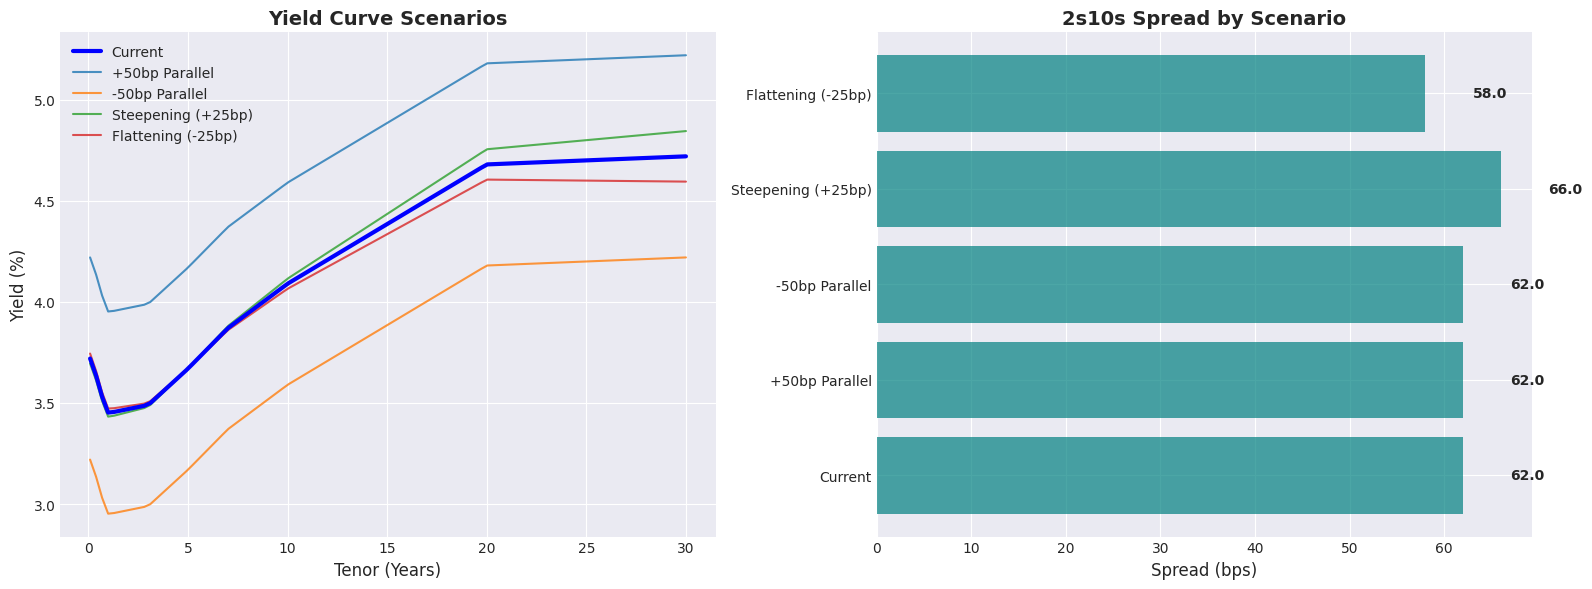

In [51]:
# Visualizing Scenarios
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: Curves
for name, curve in scenarios.items():
    curve_rates = [curve.spot_rate(t) * 100 for t in t_grid]
    if name == 'Current':
        ax1.plot(t_grid, curve_rates, label=name, color='blue', lw=3, zorder=5)
    else:
        ax1.plot(t_grid, curve_rates, label=name, alpha=0.8)

ax1.set_title("Yield Curve Scenarios", fontweight='bold')
ax1.set_xlabel("Tenor (Years)")
ax1.set_ylabel("Yield (%)")
ax1.legend()

# Right Plot: Spreads
ax2.barh(scenario_df['Scenario'], scenario_df['2s10s (bps)'], color='teal', alpha=0.7)
for i, v in enumerate(scenario_df['2s10s (bps)']):
    ax2.text(v + (5 if v > 0 else -35), i, f"{v:.1f}", va='center', fontweight='bold')

ax2.set_title("2s10s Spread by Scenario", fontweight='bold')
ax2.set_xlabel("Spread (bps)")
plt.tight_layout()
plt.show()





## Portfolio Manager Analytics: Advanced Visuals

To conclude our analysis, we present additional metrics and visualizations tailored for institutional portfolio management, focusing on model components, market expectations, and historical trends.


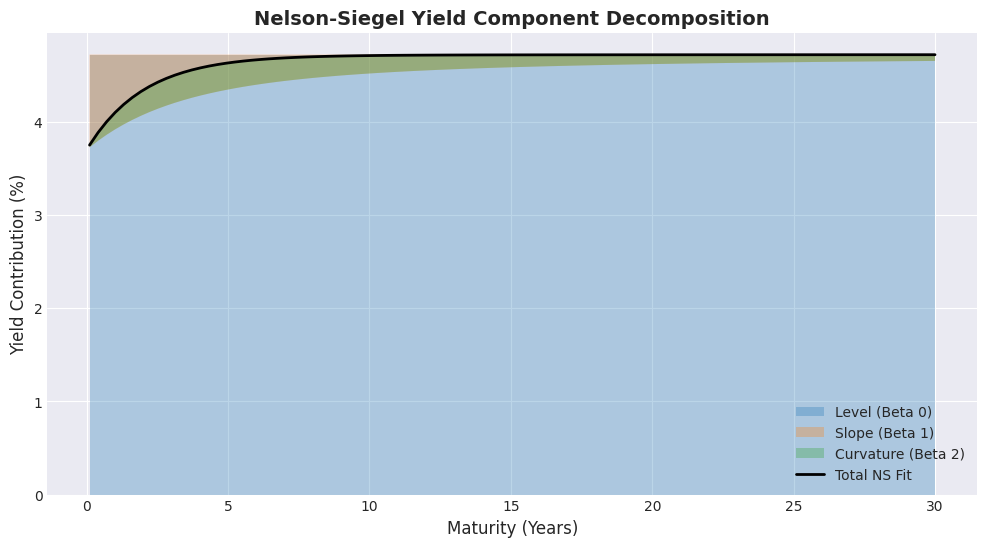

In [52]:
# 1. Nelson-Siegel Component Decomposition
# Shows the contribution of Level, Slope, and Curvature across the maturity spectrum

def ns_contribution(t, params):
    # Level: Beta0
    # Slope: Beta1 * (1 - exp(-t/tau)) / (t/tau)
    # Curvature: Beta2 * ((1 - exp(-t/tau)) / (t/tau) - exp(-t/tau))
    
    # Avoid division by zero at t=0
    t = max(t, 1e-6)
    
    term1 = (1 - np.exp(-t/params.tau)) / (t/params.tau)
    term2 = term1 - np.exp(-t/params.tau)
    
    return {
        'Level': params.beta0 * 100,
        'Slope': params.beta1 * term1 * 100,
        'Curvature': params.beta2 * term2 * 100
    }

t_grid_ns = np.linspace(0.1, 30, 100)
level = []
slope = []
curvature = []

for t in t_grid_ns:
    contrib = ns_contribution(t, ns_params)
    level.append(contrib['Level'])
    slope.append(contrib['Slope'])
    curvature.append(contrib['Curvature'])

plt.figure(figsize=(12, 6))
plt.stackplot(t_grid_ns, level, slope, curvature, labels=['Level (Beta 0)', 'Slope (Beta 1)', 'Curvature (Beta 2)'], alpha=0.3)
plt.plot(t_grid_ns, np.array(level) + np.array(slope) + np.array(curvature), color='black', lw=2, label='Total NS Fit')
plt.title("Nelson-Siegel Yield Component Decomposition", fontweight='bold')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield Contribution (%)")
plt.legend(loc='lower right')
plt.show()


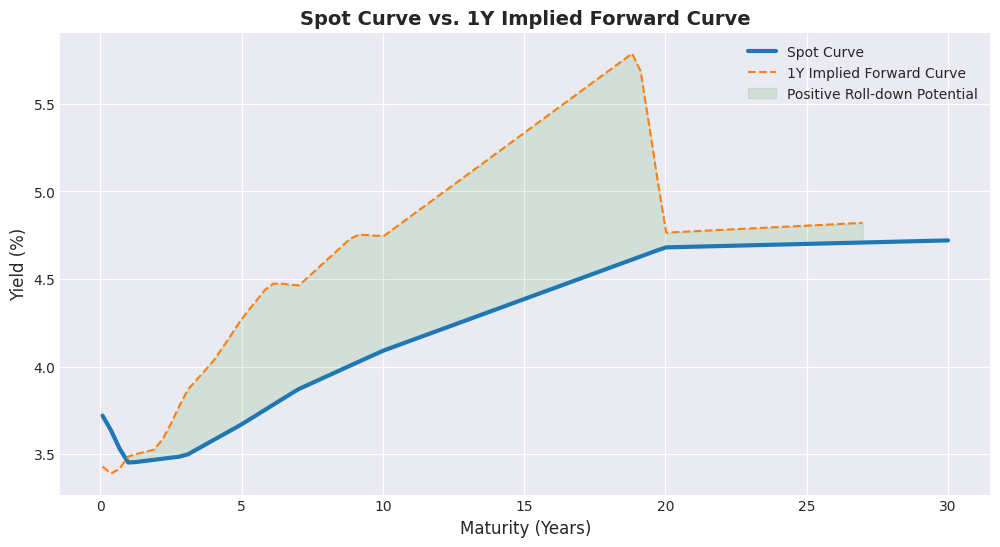

In [53]:
# 2. Spot vs. Implied Forward Curve
# Visualizes the 'break-even' rates for various investment horizons

forward_grid = [market_curve.forward_rate(t, t+1) * 100 for t in t_grid[:-10]] # 1Y forwards starting at t

plt.figure(figsize=(12, 6))
plt.plot(t_grid, [market_curve.spot_rate(t)*100 for t in t_grid], label='Spot Curve', lw=3)
plt.plot(t_grid[:-10], forward_grid, label='1Y Implied Forward Curve', linestyle='--')
plt.fill_between(t_grid[:-10], [market_curve.spot_rate(t)*100 for t in t_grid[:-10]], forward_grid, 
                 where=(np.array(forward_grid) > np.array([market_curve.spot_rate(t)*100 for t in t_grid[:-10]])),
                 interpolate=True, color='green', alpha=0.1, label='Positive Roll-down Potential')
plt.title("Spot Curve vs. 1Y Implied Forward Curve", fontweight='bold')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.show()


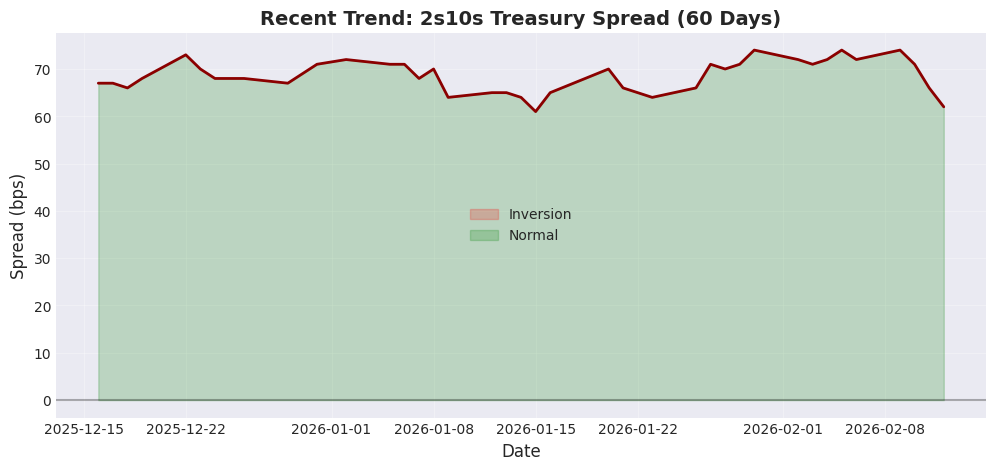

In [54]:
# 3. Historical Trend Analysis (Last 60 Days)
# Tracking the 2s10s spread as a recession/recovery signal

if historical_data is not None:
    try:
        # Calculate daily 2s10s spread
        hist_spread = (historical_data['DGS10'] - historical_data['DGS2']) * 100
        hist_spread = hist_spread.dropna()
        
        plt.figure(figsize=(12, 5))
        plt.plot(hist_spread.index, hist_spread.values, color='darkred', lw=2)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.fill_between(hist_spread.index, hist_spread.values, 0, 
                         where=(hist_spread.values < 0), color='red', alpha=0.2, label='Inversion')
        plt.fill_between(hist_spread.index, hist_spread.values, 0, 
                         where=(hist_spread.values >= 0), color='green', alpha=0.2, label='Normal')
        
        plt.title("Recent Trend: 2s10s Treasury Spread (60 Days)", fontweight='bold')
        plt.ylabel("Spread (bps)")
        plt.xlabel("Date")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Could not generate historical trend: {e}")


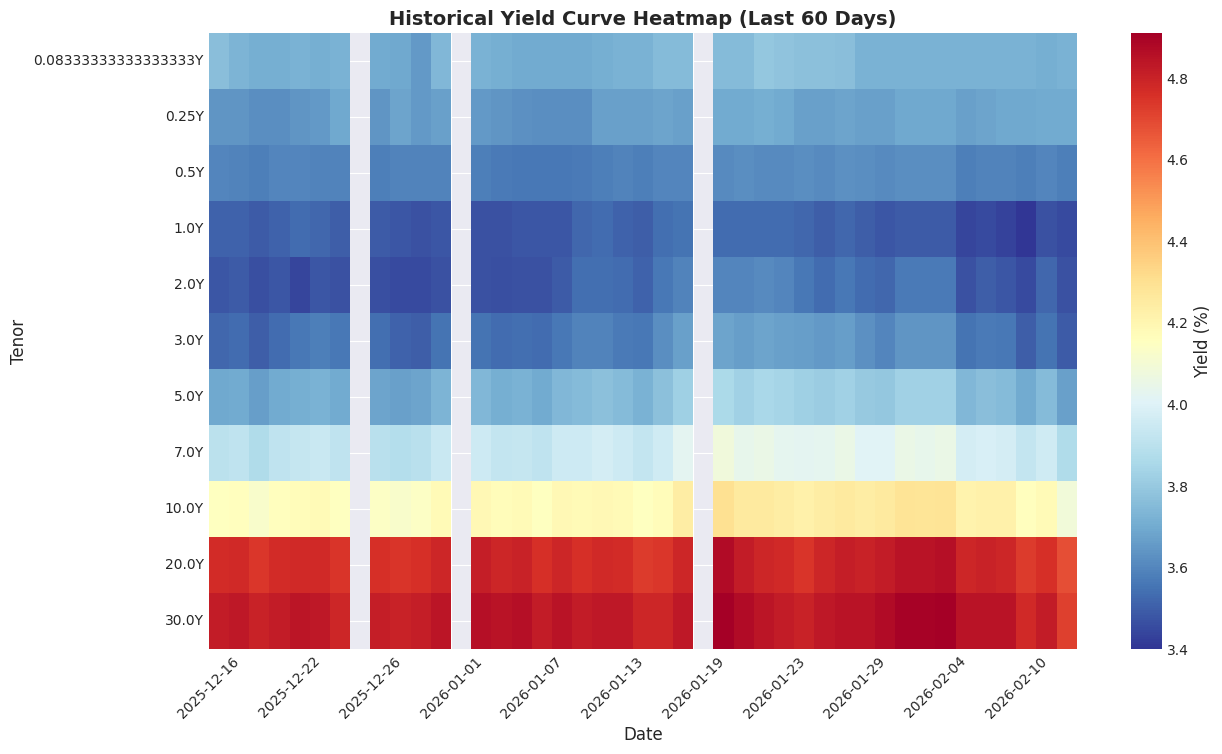

In [55]:
# 4. Yield Curve Heatmap (Last 60 Days)
# Visualizes the evolution of the entire curve over time

if historical_data is not None:
    try:
        # Prepare data for heatmap
        # Filter only CMT series and sort by tenor
        cmt_series = [s for s in historical_data.columns if s in treasury_series]
        cmt_data = historical_data[cmt_series].copy()
        cmt_data.columns = [f"{treasury_series[s]}Y" for s in cmt_data.columns]
        cmt_data = cmt_data.sort_index(axis=1, key=lambda x: [float(col[:-1]) for col in x])
        
        plt.figure(figsize=(14, 8))
        sns.heatmap(cmt_data.T, cmap='RdYlBu_r', annot=False, cbar_kws={'label': 'Yield (%)'})
        plt.title("Historical Yield Curve Heatmap (Last 60 Days)", fontweight='bold')
        plt.xlabel("Date")
        plt.ylabel("Tenor")
        # Fix x-axis labels to show dates clearly
        n = max(1, len(cmt_data) // 10)
        plt.xticks(np.arange(0, len(cmt_data), n), [d.strftime('%Y-%m-%d') for d in cmt_data.index[::n]], rotation=45)
        plt.show()
    except Exception as e:
        print(f"Could not generate heatmap: {e}")


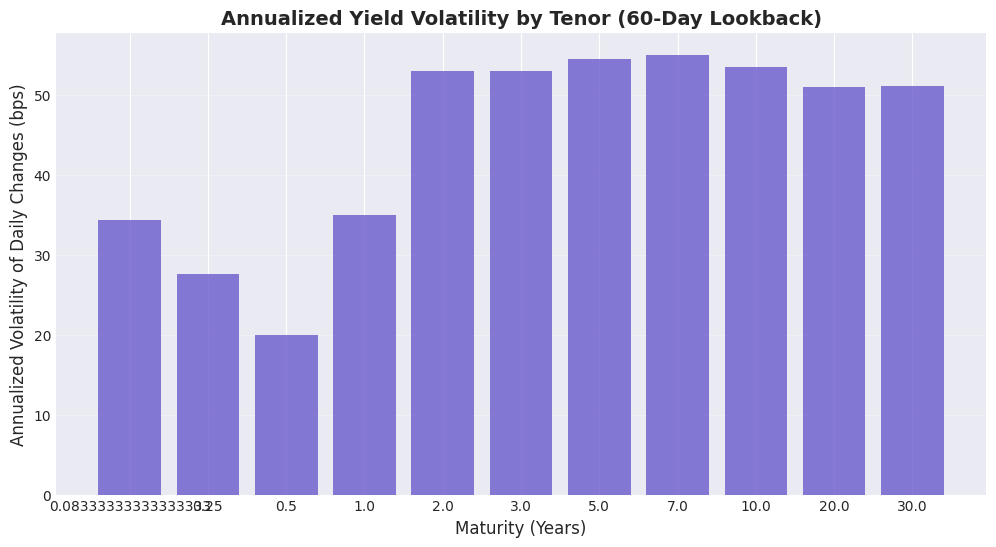

In [56]:
# 5. Yield Volatility by Tenor
# Identifies which points on the curve have experienced the most movement

if historical_data is not None:
    try:
        # Calculate daily change volatility (annualized)
        daily_diff = historical_data.diff().dropna()
        vol = daily_diff.std() * np.sqrt(252) # Annualized std of daily point changes
        vol_df = pd.DataFrame({
            'Tenor': [treasury_series[s] for s in vol.index],
            'Vol (bps)': vol.values * 100
        }).sort_values('Tenor')
        
        plt.figure(figsize=(12, 6))
        plt.bar(vol_df['Tenor'].astype(str), vol_df['Vol (bps)'], color='slateblue', alpha=0.8)
        plt.title("Annualized Yield Volatility by Tenor (60-Day Lookback)", fontweight='bold')
        plt.xlabel("Maturity (Years)")
        plt.ylabel("Annualized Volatility of Daily Changes (bps)")
        plt.grid(axis='y', alpha=0.3)
        plt.show()
    except Exception as e:
        print(f"Could not generate volatility chart: {e}")


In [57]:
from IPython.display import Markdown, display

# Final Summary & Takeaways (moved to the end for better flow)
summary_text = f"""
## Summary & Key Takeaways

### 1. Current Market Regime
Based on the analysis, the U.S. Treasury curve currently exhibits a **{shape_val}** profile. This shape reflects current market expectations regarding inflation and Federal Reserve policy. 

### 2. Forward Rate Implications
The 5y5y forward rate relative to the 10Y spot suggests that the market is pricing in a future where rates will likely {('rise' if f5y5y > s10y else 'decline')}. This is critical for assessing the "roll-down" potential of fixed-income portfolios.

### 3. Scenario Sensitivities
- **Parallel Shifts**: A 50bp upward shift represents a significant headwind for long-duration assets.
- **Curvature Changes**: The steepening and flattening scenarios highlight that risk is not just about the level of rates, but also the relative attractiveness of different points on the curve.

### 4. Risk Management Notes
Portfolio managers should monitor the stability of the Nelson-Siegel curvature (Beta 2), as spikes in curvature often precede volatility in spread-based strategies. The observed volatility in the {vol_df.iloc[vol_df['Vol (bps)'].idxmax()]['Tenor']}Y sector suggests tactical opportunities or risks in that maturity bucket.

### Next Steps
In the next notebook, we will integrate these yield curve scenarios into a multi-period cash flow model to calculate Value-at-Risk (VaR) and Earnings-at-Risk (EaR) for a diversified institutional portfolio.
"""
display(Markdown(summary_text))



## Summary & Key Takeaways

### 1. Current Market Regime
Based on the analysis, the U.S. Treasury curve currently exhibits a **STEEP** profile. This shape reflects current market expectations regarding inflation and Federal Reserve policy. 

### 2. Forward Rate Implications
The 5y5y forward rate relative to the 10Y spot suggests that the market is pricing in a future where rates will likely rise. This is critical for assessing the "roll-down" potential of fixed-income portfolios.

### 3. Scenario Sensitivities
- **Parallel Shifts**: A 50bp upward shift represents a significant headwind for long-duration assets.
- **Curvature Changes**: The steepening and flattening scenarios highlight that risk is not just about the level of rates, but also the relative attractiveness of different points on the curve.

### 4. Risk Management Notes
Portfolio managers should monitor the stability of the Nelson-Siegel curvature (Beta 2), as spikes in curvature often precede volatility in spread-based strategies. The observed volatility in the 7.0Y sector suggests tactical opportunities or risks in that maturity bucket.

### Next Steps
In the next notebook, we will integrate these yield curve scenarios into a multi-period cash flow model to calculate Value-at-Risk (VaR) and Earnings-at-Risk (EaR) for a diversified institutional portfolio.


In [58]:
# Export Results
import os
try:
    if not os.path.exists('data'):
        os.makedirs('data')
    scenario_df.to_csv('data/scenario_analysis_output.csv', index=False)
    print("Successfully exported scenario analysis to 'data/scenario_analysis_output.csv'")
except Exception as e:
    print(f"Export failed: {e}")

print(f"\nCompletion Summary:")
print(f"Date: {datetime.datetime.now().strftime('%Y-%m-%d')}")
print(f"Number of Scenarios: {len(scenarios)}")
print(f"Data Source: FRED (U.S. Treasury CMT Series)")


Successfully exported scenario analysis to 'data/scenario_analysis_output.csv'

Completion Summary:
Date: 2026-02-13
Number of Scenarios: 5
Data Source: FRED (U.S. Treasury CMT Series)
